In [ ]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [ ]:
url = 'https://raw.githubusercontent.com/sanding28/dataset/main/spam_ham_dataset.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


# Preprocessing

In [ ]:
df.drop(['label_num'], inplace=True, axis=1)
df.head()

,Unnamed: 0,label,text
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...


In [ ]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [ ]:
df.describe()

,label,text
count,5171,5171
unique,2,4993
top,ham,Subject: calpine daily gas nomination\r\n>\r\n...
freq,3672,20


In [ ]:
df.groupby('label').describe().T

label                                                      ham           spam
text count                                                3672           1499
     unique                                               3531           1462
     top     Subject: calpine daily gas nomination\r\n>\r\n...  Subject: \r\n
     freq                                                   20             16

## Cleaning Data

In [ ]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('\(.*?\)', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [ ]:
data_clean = pd.DataFrame(df.text.apply(round1))

In [ ]:
data_clean

,text
0,subject enron methanol meter 988291 th...
1,subject hpl nom for january 9 2001 hp...
2,subject neon retreat ho ho ho we re arou...
3,subject photoshop windows office cheap ...
4,subject re indian springs this deal is to ...
...,...
5166,subject put the 10 on the ft the transport v...
5167,subject 3 4 2000 and following noms hpl ...
5168,subject calpine daily gas nomination j...
5169,subject industrial worksheets for august 2000...


In [ ]:
data_clean.head()

,text
0,subject enron methanol meter 988291 th...
1,subject hpl nom for january 9 2001 hp...
2,subject neon retreat ho ho ho we re arou...
3,subject photoshop windows office cheap ...
4,subject re indian springs this deal is to ...


In [ ]:
df['text'] = data_clean['text']
df.head()

,label,text
0,ham,subject enron methanol meter 988291 th...
1,ham,subject hpl nom for january 9 2001 hp...
2,ham,subject neon retreat ho ho ho we re arou...
3,spam,subject photoshop windows office cheap ...
4,ham,subject re indian springs this deal is to ...


## Splitting Data antara ham dan spam

### Menghapus kata 'subject' dari data spam

In [ ]:
spam_text = (df.loc[df['label'] == 'spam'].text)
spam_text = spam_text.map(lambda x: x.lstrip('subject'))
spam_text

3         photoshop   windows   office   cheap   main ...
7         looking for medication   we   re the best so...
10        vocable   rnd   word asceticism  vcsc   bran...
11        report 01405    wffur attion brom est inst s...
13        vic   odin n   ow  berne hotbox carnal bride...
                              ...                        
5159      pictures  streamlined denizen ajar chased  h...
5161      penny stocks are about timing  nomad interna...
5162      anomaly boys from 3881  uosda apaproved mled...
5164      slutty milf wants to meet you  take that    ...
5170      important online banking alert  dear valued ...
Name: text, Length: 1499, dtype: object

### Menghapus kata 'subject' dari data ham

In [ ]:
ham_text = (df.loc[df['label'] == 'ham'].text)
ham_text = ham_text.map(lambda x: x.lstrip('subject'))
ham_text

0         enron methanol   meter     988291  this is a...
1         hpl nom for january 9   2001       hplnol 09...
2         neon retreat  ho ho ho   we   re around to t...
4         re   indian springs  this deal is to book th...
5         ehronline web address change  this message i...
                              ...                        
5165      fw   crosstex energy   driscoll ranch   1   ...
5166      put the 10 on the ft  the transport volumes ...
5167      3   4   2000 and following noms  hpl can   t...
5168      calpine daily gas nomination        julie   ...
5169      industrial worksheets for august 2000 activi...
Name: text, Length: 3672, dtype: object

## Word Cloud Ham

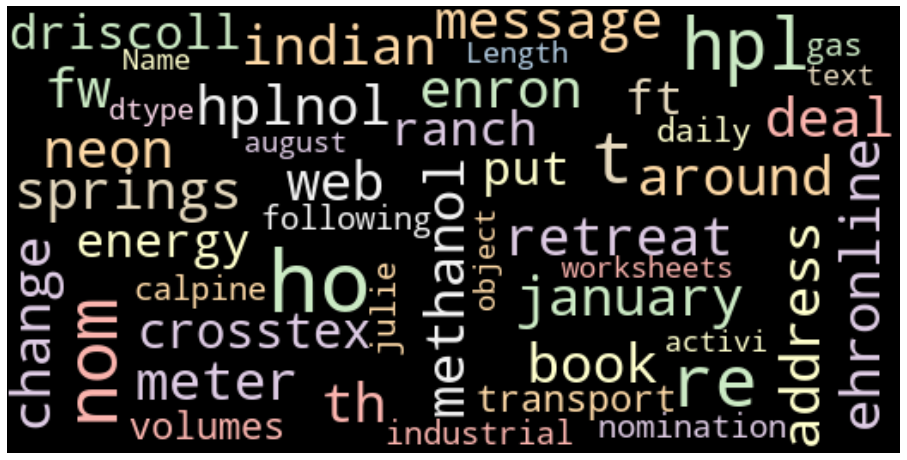

In [ ]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(str(ham_text))
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

## Word Cloud Spam

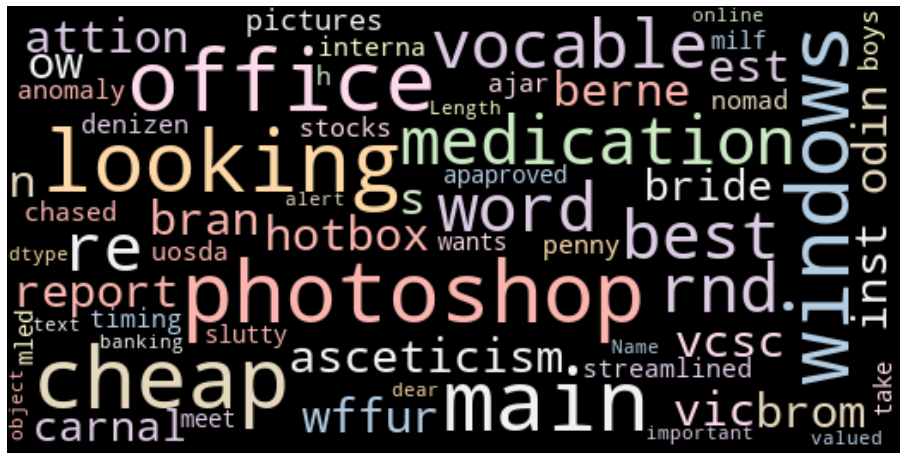

In [ ]:
spam_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(str(spam_text))
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'The distribution of ham and spam messages')

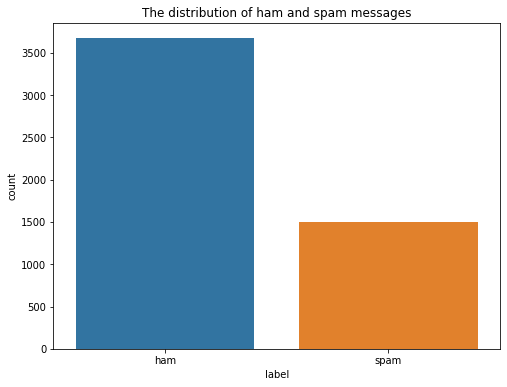

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('The distribution of ham and spam messages')

###coba down sample

In [ ]:
# downsample the ham msg
ham_msg_df = df[df['label'] == 'ham'].sample(n = len(spam_text), random_state = 44)
spam_msg_df = df[df['label'] == 'spam']

In [ ]:
ham_msg_df.describe()

,label,text
count,1499,1499
unique,1,1464
top,ham,subject calpine daily gas nomination rick...
freq,1499,6


In [ ]:
spam_msg_df.describe()

,label,text
count,1499,1499
unique,1,1462
top,spam,subject
freq,1499,16


In [ ]:
frames = [ham_msg_df, spam_msg_df]
result = pd.concat(frames)
result.describe()

,label,text
count,2998,2998
unique,2,2926
top,ham,subject
freq,1499,16


In [ ]:
result.head()

,label,text
3554,ham,subject natural gas nomination for 5 01 en...
1771,ham,subject interview schedule for liz bellamy ...
2960,ham,subject mgi supply ...
299,ham,subject ...
3944,ham,subject clickathome portal is here version...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'The distribution of ham and spam messages')

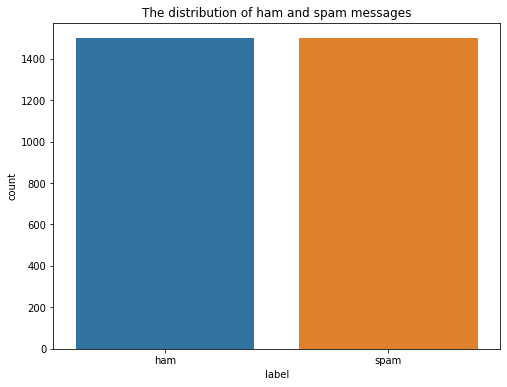

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(result.label)
plt.title('The distribution of ham and spam messages')

In [ ]:
# Get length column for each text
result['text_length'] = result['text'].apply(len)

In [ ]:
result['text_type'] = result['label'].map({'ham':0, 'spam':1})

In [ ]:
msg_label = result['text_type'].values

In [ ]:
result.head()

,label,text,text_length,text_type
3554,ham,subject natural gas nomination for 5 01 en...,399,0
1771,ham,subject interview schedule for liz bellamy ...,335,0
2960,ham,subject mgi supply ...,754,0
299,ham,subject ...,375,0
3944,ham,subject clickathome portal is here version...,586,0


In [ ]:
result['text'] = result['text'].map(lambda x: x.lstrip('subject'))
result.head()

,label,text,text_length,text_type
3554,ham,natural gas nomination for 5 01 enron met...,399,0
1771,ham,interview schedule for liz bellamy today ...,335,0
2960,ham,mgi supply ...,754,0
299,ham,...,375,0
3944,ham,clickathome portal is here version 2 0 ...,586,0


In [ ]:
##gantian
x_train, x_test, y_train, y_test = train_test_split(result['text'], msg_label, test_size=0.2, random_state=434)

In [ ]:
# Defining pre-processing parameters
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

38876

In [ ]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (2398, 50)
Shape of testing tensor:  (600, 50)


##DENSE MODEL

In [ ]:
# Define parameter
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)
#patience 5 berhenti di epoch 20

Epoch 1/30
75/75 - 0s - loss: 0.7333 - accuracy: 0.7927 - val_loss: 0.4284 - val_accuracy: 0.8300 - 235ms/epoch - 3ms/step
Epoch 2/30
75/75 - 0s - loss: 0.3015 - accuracy: 0.8761 - val_loss: 0.3292 - val_accuracy: 0.8567 - 199ms/epoch - 3ms/step
Epoch 3/30
75/75 - 0s - loss: 0.2529 - accuracy: 0.8957 - val_loss: 0.2871 - val_accuracy: 0.8817 - 214ms/epoch - 3ms/step
Epoch 4/30
75/75 - 0s - loss: 0.2212 - accuracy: 0.9103 - val_loss: 0.2600 - val_accuracy: 0.8983 - 221ms/epoch - 3ms/step
Epoch 5/30
75/75 - 0s - loss: 0.1961 - accuracy: 0.9208 - val_loss: 0.2409 - val_accuracy: 0.9033 - 213ms/epoch - 3ms/step
Epoch 6/30
75/75 - 0s - loss: 0.1806 - accuracy: 0.9283 - val_loss: 0.2232 - val_accuracy: 0.9133 - 225ms/epoch - 3ms/step
Epoch 7/30
75/75 - 0s - loss: 0.1670 - accuracy: 0.9333 - val_loss: 0.2125 - val_accuracy: 0.9183 - 242ms/epoch - 3ms/step
Epoch 8/30
75/75 - 0s - loss: 0.1566 - accuracy: 0.9383 - val_loss: 0.1993 - val_accuracy: 0.9217 - 210ms/epoch - 3ms/step
Epoch 9/30
75/75

In [ ]:
model.evaluate(testing_padded, y_test)
# 0s 10ms/step - loss: 0.0873 - accuracy: 0.9599

19/19 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9533


[0.14911289513111115, 0.95333331823349]

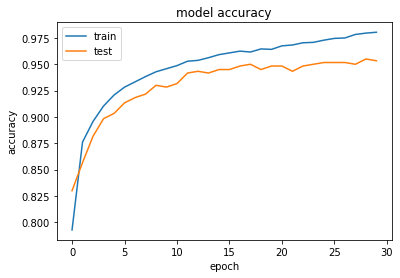

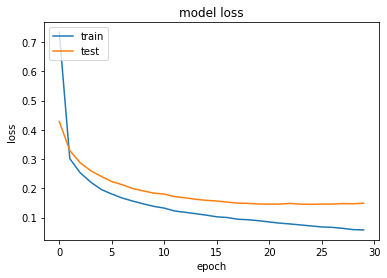

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

10/10 - 0s - loss: 0.0508 - accuracy: 0.9833 - 37ms/epoch - 4ms/step
3/3 - 0s - loss: 0.1491 - accuracy: 0.9533 - 23ms/epoch - 8ms/step
Train accuracy: 98.33
Valid accuracy: 95.33


##LSTM

In [ ]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model 
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model2.add(SpatialDropout1D(drop_lstm))
model2.add(LSTM(n_lstm, return_sequences=False))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 16)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 82,369
Trainable params: 82,369
Non-trainable params: 0
__________________________________________________

In [ ]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model2.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
75/75 - 9s - loss: 0.4496 - accuracy: 0.7544 - val_loss: 0.2007 - val_accuracy: 0.9333 - 9s/epoch - 116ms/step
Epoch 2/30
75/75 - 6s - loss: 0.1701 - accuracy: 0.9416 - val_loss: 0.1885 - val_accuracy: 0.9300 - 6s/epoch - 86ms/step
Epoch 3/30
75/75 - 6s - loss: 0.1331 - accuracy: 0.9637 - val_loss: 0.1348 - val_accuracy: 0.9517 - 6s/epoch - 77ms/step
Epoch 4/30
75/75 - 5s - loss: 0.1109 - accuracy: 0.9700 - val_loss: 0.1480 - val_accuracy: 0.9400 - 5s/epoch - 71ms/step
Epoch 5/30
75/75 - 5s - loss: 0.1303 - accuracy: 0.9566 - val_loss: 0.1896 - val_accuracy: 0.9217 - 5s/epoch - 70ms/step
Epoch 6/30
75/75 - 5s - loss: 0.0911 - accuracy: 0.9679 - val_loss: 0.1407 - val_accuracy: 0.9567 - 5s/epoch - 72ms/step
Epoch 7/30
75/75 - 5s - loss: 0.0797 - accuracy: 0.9787 - val_loss: 0.1340 - val_accuracy: 0.9617 - 5s/epoch - 71ms/step
Epoch 8/30
75/75 - 5s - loss: 0.0637 - accuracy: 0.9833 - val_loss: 0.2735 - val_accuracy: 0.9450 - 5s/epoch - 70ms/step
Epoch 9/30
75/75 - 5s - loss: 0

In [ ]:
model2.evaluate(testing_padded, y_test)

19/19 [==============================] - 1s 27ms/step - loss: 0.1321 - accuracy: 0.9617


[0.1320730298757553, 0.9616666436195374]

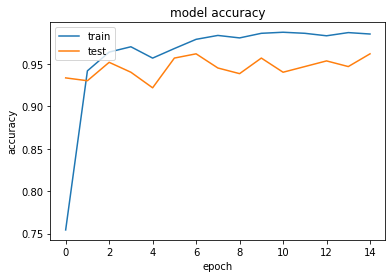

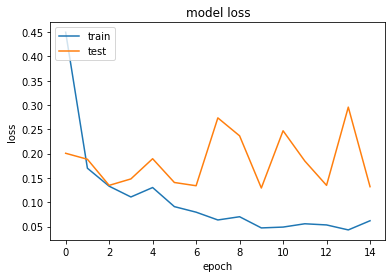

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

10/10 - 1s - loss: 0.0380 - accuracy: 0.9917 - 975ms/epoch - 98ms/step
3/3 - 0s - loss: 0.1321 - accuracy: 0.9617 - 264ms/epoch - 88ms/step
Train accuracy: 99.17
Valid accuracy: 96.17


# Text Predict

## Dense model

In [ ]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe", 
               "i hate cats because they are very annoying and super duper ugly! not to mention they are noisy and very unfriendly... SIGH"]

def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model.predict(padded))

predict_spam(predict_msg)

1/1 [==============================] - 0s 39ms/step


array([[0.9659476 ],
       [0.90925515]], dtype=float32)

## LSTM model

In [ ]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe", 
               "i hate cats because they are very annoying and super duper ugly! not to mention they are noisy and very unfriendly... SIGH"]

def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model2.predict(padded))

predict_spam(predict_msg)

1/1 [==============================] - 0s 23ms/step


array([[0.9726894 ],
       [0.14188257]], dtype=float32)

In [ ]:
# download data clean buat ngecek udah bersih atau belum datanya.
# from google.colab import files
# data_clean.to_csv('data_clean.csv', encoding = 'utf-8-sig') 
# files.download('data_clean.csv')